In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter

# %matplotlib inline


d:\Tianyu\software\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [27]:
def interpolate_pupil(data, window=90):
    data['LeftPupilD'][data['LeftPupilD']<0] = np.nan
    data['RightPupilD'][data['RightPupilD']<0] = np.nan
    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    std_left = np.std(data['LeftPupilD'])
    std_right = np.std(data['RightPupilD'])
    mean_left = np.mean(data['LeftPupilD'])
    mean_right = np.mean(data['RightPupilD'])
    data['LeftPupilD'][np.abs(data['LeftPupilD']-mean_left)>3*std_left] = np.nan
    data['RightPupilD'][np.abs(data['RightPupilD']-mean_right)>3*std_right] = np.nan
    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    data.dropna(axis=0)
    data_s = SG_fil(data,window+1,2)
    return data_s

def SG_fil(data,window,order=2):
    df = data.copy()
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        df_new[n] = savgol_filter(df.loc[:,n],window,order)
    return df_new  

In [105]:
# path = 'D:/code/python/paper_6_human_like_ik/data/process/'
path = '../data/process/'
local_name = locals()
data_raw = []
human_like_collision = []
traditional_collision = []
conditions = []

collision_statistics = pd.DataFrame(columns = ["collision_times","conditions","trail","time"])

participant_id_order = ["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"]
trail_id_order = ["01","02","03","04","05","06","07","08","09","10"]


valve_calculate = 0
for home, dirs, files in os.walk(path):
    for filename in files:
        each_collision = []
        raw=pd.read_csv(home+"/"+filename,index_col=0)
        start_point = int(raw.apply(pd.Series.first_valid_index)[['StartSignal']].values[0])
        last_point = int(raw.apply(pd.Series.last_valid_index)[['CollisionMissionTarget']].values[0])
        t=raw[start_point:last_point]
        # t=raw[1:-1]

        if(filename[0:5] == "human"):
            condition = "human_like"
            conditions.append(condition)
            participant_id = filename[15:17]
            trail_id = filename[23:25]
            human_like_group = t.groupby(['ColX', 'ColY', 'ColZ'])
            if not valve_calculate:
                for h,d in human_like_group:
                    if (h[0] != 0.0):
                        if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
                            human_like_collision.append(h)
                            each_collision.append(h)
            if valve_calculate:
                for h,d in human_like_group:
                    if (h[0] != 0.0):
                        if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
                            human_like_collision.append(h)
                            each_collision.append(h)
            collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ignore_index=True)

        if(filename[0:5] == "tradi"):
            condition = "traditional"
            conditions.append(condition)
            participant_id = filename[16:18]
            trail_id = filename[24:26]
            traditional_group = t.groupby(['ColX', 'ColY', 'ColZ'])
            if not valve_calculate:
                for h,d in traditional_group:
                    if (h[0] != 0.0):
                        if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
                            traditional_collision.append(h)
                            each_collision.append(h)
            if valve_calculate:
                for h,d in traditional_group:
                    if (h[0] != 0.0):
                        if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
                            traditional_collision.append(h)
                            each_collision.append(h)
            collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ignore_index=True)
        data_raw.append(t)


        # t['Conditions'] = t['Conditions'].str.strip()
        # print(condition + "_" + participant_id + "_" + trail_id)

In [94]:
print(len(human_like_collision))
print(len(traditional_collision))
human_like_df = pd.DataFrame(human_like_collision)
human_like_df.columns=["X","Y","Z"]
human_like_df["condition"] = "human_like"
traditional_df = pd.DataFrame(traditional_collision)
traditional_df.columns=["X","Y","Z"]
traditional_df["condition"] = "traditional"
valve_df = pd.DataFrame({'X': [-0.4878,0.0344,0.5996], 'Y':[0.3056,1.0998,0.4914], 'Z':[0.4008,0.2957,0.2871]})
valve_df["condition"] = "valve"
total_df = pd.concat([human_like_df,traditional_df,valve_df],ignore_index=True)

fig = px.scatter_3d(total_df, x='X', y='Y', z='Z',
            color='condition',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8)
fig.update_traces(marker_size = 3)
fig.show()

42
270


In [104]:
index = 36
print(conditions[index])
collision_array = []
collision_group = data_raw[index].groupby(['ColX', 'ColY', 'ColZ'])
for h,d in collision_group:
    if (h[0] != 0.0):
        # if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
        if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
            collision_array.append(h)
collision_df = pd.DataFrame(collision_array)
collision_df.columns=["X","Y","Z"]
collision_df["condition"] = "collision"
trajectory_df = data_raw[index][['Joint8X', 'Joint8Y', 'Joint8Z']]
trajectory_df.columns=["X","Y","Z"]
trajectory_df["condition"] = "trajectory"
valve_df = pd.DataFrame({'X': [-0.4878,0.0344,0.5996], 'Y':[0.3056,1.0998,0.4914], 'Z':[0.4008,0.2957,0.2871]})
valve_df["condition"] = "valve"
total_df = pd.concat([collision_df,trajectory_df,valve_df],ignore_index=True)

fig = px.scatter_3d(total_df, x='X', y='Y', z='Z',
            color='condition',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8)
fig.update_traces(marker_size = 3)

fig.show()

traditional


<ipython-input-104-584b74259615>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-104-584b74259615>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-104-584b74259615>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.scatter_3d(total_df, x='X', y='Y', z='Z',
            color='condition',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8)

bright_blue = [[0, '#7DF9FF'], [1, '#7DF9FF']]
zero_pt = pd.Series([0])
x = zero_pt.append(total_df['X'], ignore_index = True).reset_index(drop = True)
y = zero_pt.append(total_df['Y'], ignore_index = True).reset_index(drop = True)
z = zero_pt.append(total_df['Z'], ignore_index = True).reset_index(drop = True)
length_data = len(y)
z_plane_pos = 40*np.ones((length_data,length_data))

# fig.add_trace(go.Surface(x=x, y=y, z=z_plane_pos, colorscale=bright_blue,  showscale=False))
# fig.add_trace(go.Surface(x=x.apply(lambda x: 10), y=y, z = np.array([z]*length_data), colorscale= bright_blue, showscale=False))
# fig.add_trace(go.Surface(x=x, y= y.apply(lambda x: 0.1925), z =  np.array([z]*length_data).transpose(), colorscale=bright_blue, showscale=False))
fig.show()



In [ ]:
for h,d in traditional_group:
    if (h[0] != 0.0):
        if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
            print(d[["CollisionTarget","CollisionJoint"]])
for h,d in human_like_group:
    if (h[0] != 0.0):
        if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
            print(d[["CollisionTarget","CollisionJoint"]])

In [ ]:
test = t.groupby(['CollisionTarget', 'CollisionJoint'])
for h,d in test:
    print(h)

In [ ]:
test_1 = t.groupby(['ColX', 'ColY', 'ColZ'])
for h,d in test_1:
    print(h)

In [5]:
collision_statistics

,collision_times,conditions,trail
0,1,human_like,01
1,0,human_like,02
2,0,human_like,03
3,2,human_like,04
4,1,human_like,05
...,...,...,...
115,1,traditional,06
116,5,traditional,07
117,2,traditional,08
118,1,traditional,09


In [2]:
path = 'D:/code/python/nasa/data/result/0420_start_end/start_entropy/entropy/'
name = 'B'
data = pd.read_csv(path + name + '_combine.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
traditional v.s. human_like: Wilcoxon test (paired samples), P_val=1.128e-04 stat=3.905e+02


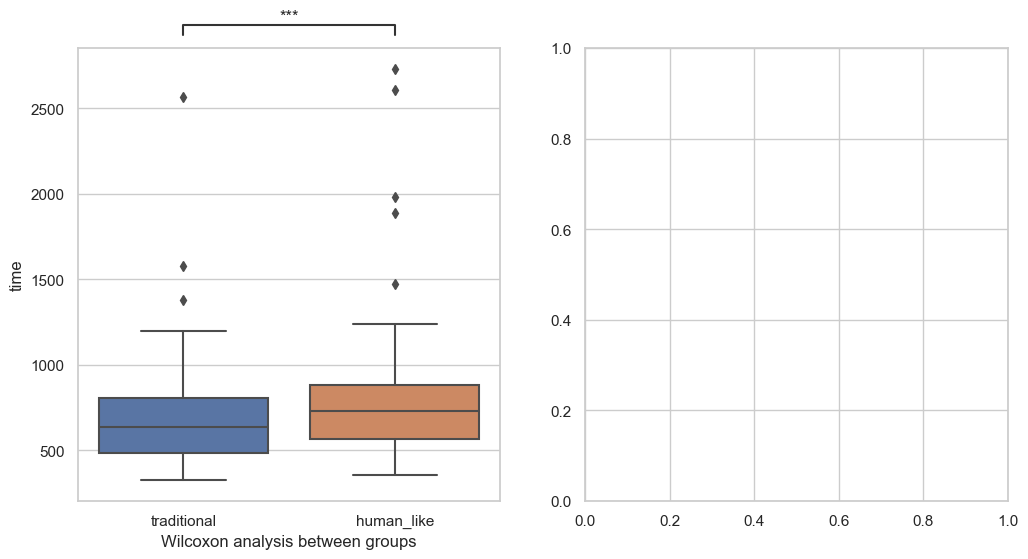

In [110]:
### pair analysis visualization 

sns.set(style = 'whitegrid')
x = 'conditions'
y = 'time' # 'collision_times', 'time'
order = [ "traditional","human_like"]
method = 'Wilcoxon' #'Kruskal','Wilcoxon'

fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)

if 1:
   axes[0] = sns.boxplot(ax = axes[0], data=collision_statistics, x=x, y=y, order=order)
   test_results = add_stat_annotation(ax=axes[0], data=collision_statistics, x=x, y=y, order=order,
                                    box_pairs=[(order[0], order[1])],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

if 0:
   axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,
                  # palette = 'mako',
                  # linewidth=1.5,
                  # errcolor="0.2",errwidth =1.5,
                  # edgecolor=".2",
                  # facecolor=(1, 1, 1, 0)
                  )
   test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                    box_pairs=[(order[1], order[2]),(order[1], order[3]),(order[2], order[3])],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -0.5,
                                 #    line_offset= -0.5,
                                    #   stats_params={'alternative': 'greater'}
                                    )
   axes[1].set(xlabel = method + ' analysis between groups', ylabel='')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

human_like_01 v.s. human_like_02: Kruskal-Wallis paired samples, P_val=1.495e-01 stat=2.077e+00
traditional_01 v.s. traditional_02: Kruskal-Wallis paired samples, P_val=1.495e-01 stat=2.077e+00
human_like_01 v.s. human_like_10: Kruskal-Wallis paired samples, P_val=1.631e-02 stat=5.769e+00
traditional_01 v.s. traditional_10: Kruskal-Wallis paired samples, P_val=1.631e-02 stat=5.769e+00


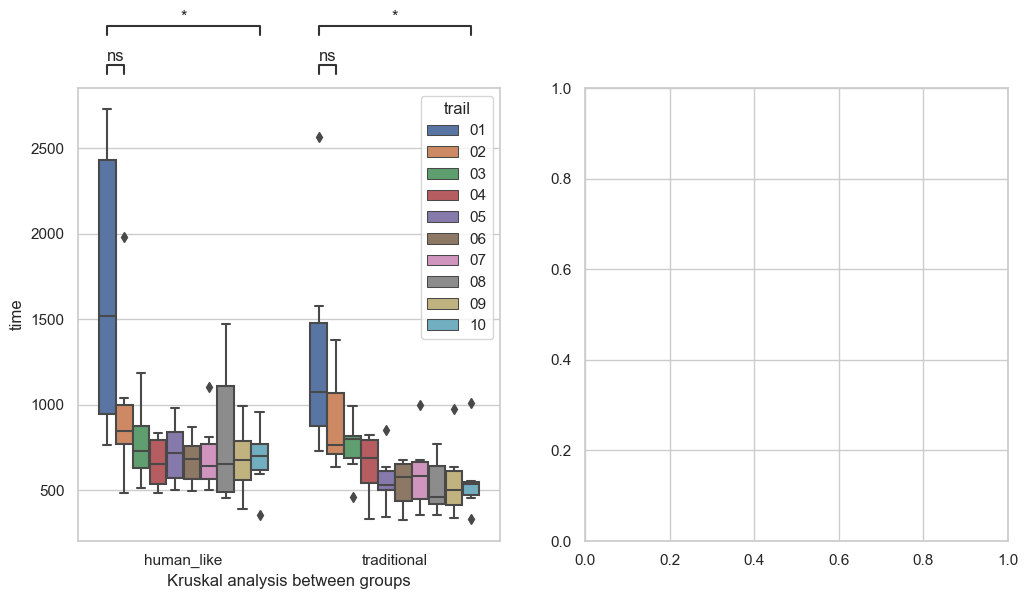

In [112]:
### pair analysis visualization start end
sns.set(style = 'whitegrid')
x = 'conditions'
y = 'time' # 'collision_times', 'time'
hue = 'trail'
order = ["traditional","human_like"]
trail_states = ["01","02","03","04","05","06","07","08","09","10"]
method = 'Kruskal'
state = 1



fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)
if 1:
   axes[0] = sns.boxplot(ax = axes[0], data=collision_statistics, x=x, y=y, hue=hue)
   test_results = add_stat_annotation(ax=axes[0], data=collision_statistics, x=x, y=y, hue=hue,
                                    box_pairs=[
                                       ((order[1], trail_states[0]), (order[1], trail_states[1])),
                                       ((order[1], trail_states[0]), (order[1], trail_states[9])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[1])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[9])),
                                       ],
                                    test=method, 
                                    # test='Wilcoxon', 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   # axes[0].set(xlabel='Paired analysis between conditions (Greater)', ylabel='VRSQ score')
   # axes[0].set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')
   # axes[0].set(xlabel='Wilcoxon analysis between groups', ylabel='Mission time (s)')
   axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
   # axes[0].legend_.remove()
if 0:
   axes[1] = sns.boxplot(ax = axes[1], data=data, x=x, y=y, hue=hue)
   test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y, hue=hue,
                                    box_pairs=[
                                       ((order[1], point_states[state]), (order[2], point_states[state])),
                                       ((order[1], point_states[state]), (order[3], point_states[state])),
                                       ((order[2], point_states[state]), (order[3], point_states[state])),
                                       ],
                                    test=method, 
                                    # test='Wilcoxon', 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   # axes[0].set(xlabel='Paired analysis between conditions (Greater)', ylabel='VRSQ score')
   # axes[0].set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')
   # axes[0].set(xlabel='Wilcoxon analysis between groups', ylabel='Mission time (s)')
   axes[1].set(xlabel = method + ' analysis between groups')
   plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
